# Sabina Hartnett
# Week 3 - Sampling & Reliability

build a corpus for preliminary analysis and articulate what your sample represents in context of your final project. 
begin by exploring how we can get *human* readings of content at scale. 
We want to gather and utilize human responses for several reasons. First, we may want to use crowdsourced human scores as the primary method of coding, extracting or organizing content (as it was in two of the assigned readings). Second, we may want to validate or tune a computational algorithm we may have developed in terms of how it is associated with human meanings or experience. Finally, we may want to use human coding on a sample of data as the basis for training a model or algorithm to then extrapolate *human-like* annotations to the entire population. Here intelligent sampling is critical to maximize effective maching training.

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math


#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## <span style="color:red">*Pitch the Domain of your Project*</span>

<span style="color:red">In the two cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words) and **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words)? [**Note**: your individual or collective project can change over the course of the quarter if new data and/or analysis opportunities arise or if old ones fade away.]

## ***What?*** 
For our final project, Egemen Partha and I will analyze Twitter data (collected from Twitter API) which is categorized by personality types included in user bios. We intend to learn about the way various self-identified personality types interact with the platform (i.e. do extroverted users tweet more, do 'Judging' users interact more with other tweets?). This research is reminiscant of Nicole Ellisons research on user-types (although her research was based on observations made in 'reali life' (not only via the platform)). This work will be contenxtualized in physchological/behavior studies of the various personality types.

## ***Why?***
Personally, via my own social media (&Twitter) interactions and self-reflections, I think it is interesting to try to understand correlations between user patterns and 'innate' user qualities. This research will be interesting for individual users as well as informing platform design and potentially regulation. Even just understanding which personality types are more present on the platform (or, more readily identify themselves with their personality type) is interesting when thinking about the structure and purpose of platforms like Twitter.

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication)? (<200 words).

We are planning to look at a dataset of around 1600 users and their liked tweets. Since actual tweets would likely return a bias toward Extroverted types (more likely to tweet / use unique (and/or) controversial language and topics) we decided to look at liked tweets as a metric of the users personal interests (we would argue this is far less performative than the user-created tweets). Overall, this is a study which intersects social media platform usage and human interaction. The limitations are big: we only have access to what is published on twitter (public accounts which decide to include their personality types and those accounts' likes from other public accounts) and we assume here that people are trustworthy in their personality-type self-reports. Alternatively, platforms like Facebook could be interesting but they, more often than twitter include a more personal network - introducing other limitations and biases. We could scale up the sample by collecting additional information on the users: potentially their own Tweets, other twitter metrics, or even an attempt to combine their profile information with other personal info (scraped from FB or so)...

## <span style="color:red">*Your turn*</span>

<span style="color:red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the MTurk slides in the Assignment link on Canvas, or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

# in this notebook:
In this notebook specifically I will be using a questionaire about percieved Twitter user personality type. I asked users to complete the following (for this notebook I decided to save some money and use my personal network :) ):

.............................................................................

On a scale of 1 to 10, where 1 is an action more indicative of introverted tendencies and 10 is an action of more extroverted tendencies, please rank the following actions:

Using Twitter (incl. scrolling, liking, retweeting, tweeting) (1-10):

Scrolling through Twitter without interacting (liking/retweeting) with posts (1-10):

Liking other people's Tweets (1-10):

Retweeting Tweets (1-10):

Tweeting regularly (1-10):

.............................................................................


Please read the following Tweet and regardless of your personal feelings about the topic, decide where do you think that someone who would tweet this falls on the spectrum described above of introverted (1) to extroverted (10):

"@otherUser As a man who has handed a jar of pickles to his wife to open way too many times.  No you don't." (1-10):

"MOST IMPORTANT: Kiddo is amazing about wearing her masks. We frame it as helping our community, emphasizing that it's our part. When she asks why others don't wear them, we say there are some who choose themselves, but the more that choose community, the sooner this will be over."(1-10):

"Everyone has these fun year-of lists for 2020, but I watched less, read less, played less, slept less because virtual kindergarten on top of a day job/writing is just exhausting and consuming. But here are some fun parenting hacks" (1-10):

"I like Presidents who weren't banned from twitter." (1-10):
..........................................................................

Data will be stored: question: column and user: row (each user will have their own row of answers corresponding col num to q num)


[Click here for loop design](loopdesign.png)

In [88]:
x = np.loadtxt("HumanTweetEval.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [89]:
anno.annotations    #num rows = num respondents (8)
# num cols = num questions (9)

array([[ 5,  4,  7,  4,  3,  6,  2,  2,  4],
       [ 7,  2,  5,  6,  5,  5,  2,  3,  3],
       [ 6,  2,  3,  7,  9,  5,  7,  7,  8],
       [ 4,  3,  5,  5,  7,  6,  5,  4,  6],
       [ 4,  1,  3,  4,  8,  5,  5,  6,  5],
       [ 3,  6,  7,  4,  2,  6,  7,  9,  7],
       [ 9,  0,  2,  4,  9, -1,  4,  4,  6],
       [ 4,  1,  4,  5,  6,  6,  5,  5,  5]])

In [90]:
anno.labels

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

In [91]:
anno.missing_values   #as specified above, missing values are entered as -1

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [92]:
pyanno.measures.agreement.labels_frequency(anno.annotations,10)

array([0.01408451, 0.02816901, 0.09859155, 0.09859155, 0.18309859,
       0.21126761, 0.15492958, 0.12676056, 0.02816901, 0.05633803])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 2. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


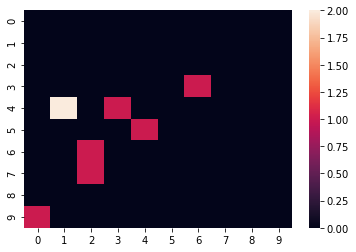

In [93]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],10)
print(c)
ac = seaborn.heatmap(c)
plt.show()

In [94]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

-0.16363636363636364

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

# Krippendorff is esp. relevant since the questions I posed were continuous "on a scale of 1-10 rate this"
Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [95]:
krippendorffs_alpha(anno.annotations[::])

-0.005002440214738835

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [96]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1]) 
# in example 0.439 - I believe this means that our data is comparably quite similar

-0.0847457627118644

In [97]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[ 1.         -0.08474576 -0.01818182 -0.16666667  0.03448276 -0.14285714
  -0.14285714 -0.05660377 -0.16363636]
 [-0.08474576  1.         -0.08474576  0.05084746 -0.06666667  0.07692308
   0.05084746 -0.10344828  0.06666667]
 [-0.01818182 -0.08474576  1.         -0.03703704  0.01754386  0.04
   0.05882353 -0.16363636 -0.01818182]
 [-0.16666667  0.05084746 -0.03703704  1.         -0.06666667 -0.2173913
   0.38461538  0.23076923  0.09433962]
 [ 0.03448276 -0.06666667  0.01754386 -0.06666667  1.          0.18367347
  -0.12280702 -0.12280702 -0.12280702]
 [-0.14285714  0.07692308  0.04       -0.2173913   0.18367347  1.
  -0.0212766  -0.14285714  0.04761905]
 [-0.14285714  0.05084746  0.05882353  0.38461538 -0.12280702 -0.0212766
   1.          0.41818182  0.27272727]
 [-0.05660377 -0.10344828 -0.16363636  0.23076923 -0.12280702 -0.14285714
   0.41818182  1.          0.14285714]
 [-0.16363636  0.06666667 -0.01818182  0.09433962 -0.12280702  0.04761905
   0.27272727  0.14285714  1.        ]

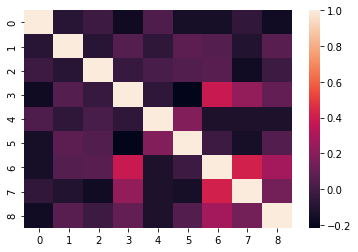

In [98]:
ax = seaborn.heatmap(m)
plt.show()

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [99]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of 
    metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations) 
#again, where example is ~0.41, our cohens k for all pairs of codersis: 0.007


0.0029177899579194786

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [100]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

-0.12621359223300965

Or averaged over the total:

In [101]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.03224552639457197

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

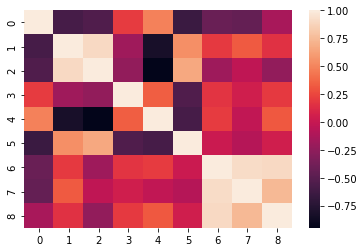

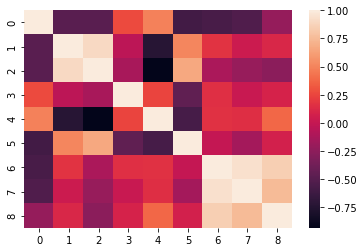

In [102]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [103]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.02153725004851071 0.015577099858102298


## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, use the results of your content annotation survey to predict high and low-quality analysts, then predict MAP estimates for your codes in question. What do these estimates suggest about the distribution of skill among your coders? How different are these estimates from a majority vote?

The cells below show the MAP estimates which are incredibly low, suggesting that the skill of the coders is quite similar.

# Models

However, what if some coders are better than others. The prior measures all rely on the assumption that all coders are equally good. What if some are worse than others? Now we use Rzhetsky et al (2009) and Dawid & Skene's models to make inference about true label classes by downweighting bad or deviant coders. Pyanno provides three relevant models: ModelA, ModelB, and ModelBt. Model A can only be currently run on a balanced 8-coder design, but assesses accuracy purely based on agreement. Model B with $\theta$s models the relationship between each coder and code. Model B is the Dawid & Skene model from the reading. The following image schematically suggests the relationship between the models. <img src="../data/models.png">

The models should provide similar results. To estimate the parameters for any models, we first need to create a new model. 

In [106]:
# create a new instance of model A, with 10 label classes
model = ModelB.create_initial_state(10, 9)
# other model parameters are initialized from the model prior
#print(model.theta)
#print(model.log_likelihood(anno.annotations))

In [107]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

Pyanno allows one to use either MLE (maximum likelihood estimation) or MAP (maximum a posteriori estimation) to estimate model parameters. Note that the parameters here correspond to our estimation of the accuracy of each annotator.

In [108]:
model.map(anno.annotations)
#print(model.theta)
#print(model.log_likelihood(anno.annotations))

In [109]:
model = ModelB.create_initial_state(10, 9)
model.map(anno.annotations)
#print(model.theta)
#print(model.log_likelihood(anno.annotations))

Once we have model parameters estimated, we can now make inferences about the true label classes. We can calculate the posterior distribution over the true label classes.

In [110]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  1.00000000e+000 2.67127509e-033 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  5.26089767e-036 1.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 1.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  6.14759471e-029 1.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  1.58682644e-294 1.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 1.00000000e+000
  0.00000000e+000 0.00000000e+000

Let's turn the posterior of the first 100 samples into a heatmap.

In [111]:
votes = []
for r in anno.annotations:
    v = [0] * len(anno.labels)
    votes.append(v)
    for a in r:
        if a > -1:
            v[a] += 1
votes_array = np.array(votes)

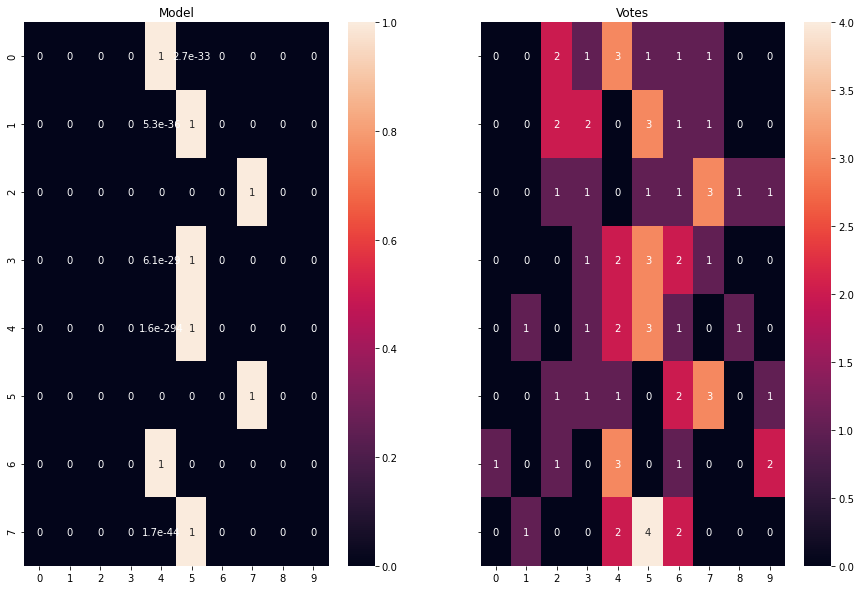

In [112]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)
num_questions = 20

seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
seaborn.heatmap(posterior[:num_questions], annot=True, ax =ax1)
ax1.set_title("Model")
ax2.set_title("Votes")
plt.show()

This differs markedly from taking annotator scores at face value (Add comparison of average values)

In [113]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [114]:
print(samples[0].mean(axis=0))
print(samples[0].std(axis=0))

[[[0.56032383 0.13513349 0.06453184 0.03894098 0.03331373 0.03310327
   0.03584787 0.03319609 0.03481294 0.03079596]
  [0.11954233 0.50406383 0.12368316 0.06323493 0.03039125 0.02946433
   0.03024762 0.03220248 0.03515425 0.03201581]
  [0.06291274 0.10767965 0.48287188 0.11982384 0.06661    0.02768124
   0.03446332 0.03121895 0.03503732 0.03170107]
  [0.02776074 0.05958004 0.12408184 0.47714943 0.12366195 0.06165363
   0.03152822 0.03441193 0.02820721 0.03196501]
  [0.03236536 0.02891905 0.05097402 0.10809541 0.47095318 0.14043645
   0.05526416 0.0317438  0.02865248 0.05259608]
  [0.02982648 0.03097311 0.02809814 0.04897205 0.1960692  0.43617033
   0.10285736 0.07240489 0.02654073 0.02808772]
  [0.02884172 0.02976292 0.02922565 0.03204509 0.06302121 0.1229491
   0.48550226 0.11776774 0.05803556 0.03284875]
  [0.02786852 0.03249139 0.02878302 0.05155483 0.0263815  0.05937676
   0.14214522 0.45764784 0.11320657 0.06054436]
  [0.02865577 0.02979489 0.03282775 0.03234446 0.02827901 0.03098

Let's try everything again with ModelBt

In [115]:
# create a new instance of model B, with 10 label classes and 9 annotators.
model = ModelBt.create_initial_state(10, 9)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.83387708 0.77885002 0.87955102 0.62307861 0.73239446 0.64417214
 0.64462554 0.86625943 0.87126632]
-205.53182428165465


In [116]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.12287733 0.25128823 0.34114275 0.55468774 0.10285891 0.24725819
 0.99999995 0.5571615  0.40575638]
-147.6109428916734


In [117]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[6.76701977e-11 1.49094260e-10 9.99999965e-01 1.38609478e-10
  3.01155417e-08 7.25125134e-10 2.02605364e-11 3.55036981e-09
  7.25058898e-11 1.53442544e-18]
 [2.53673841e-10 5.58906503e-10 9.99999929e-01 3.50404019e-08
  5.42499277e-10 3.06475242e-08 2.88010583e-10 3.60096139e-09
  2.71801298e-10 5.75206823e-18]
 [3.98880490e-12 8.78832832e-12 8.96403125e-11 3.68979230e-11
  8.53033868e-12 1.00219332e-10 5.09334502e-13 1.00000000e+00
  2.62640673e-11 9.33286150e-20]
 [1.28398806e-11 2.82894473e-11 9.55259929e-11 7.69897264e-11
  3.92027621e-10 9.99999999e-01 2.36242388e-11 1.49167252e-10
  1.37574146e-11 2.91144995e-19]
 [3.69219159e-11 2.45724069e-10 2.74691237e-10 3.41541400e-10
  1.11606139e-09 9.99999997e-01 4.23417515e-11 4.15693326e-10
  4.08210105e-11 8.37206464e-19]
 [1.76814057e-11 3.89565301e-11 1.35737875e-10 4.42529827e-11
  4.23903192e-10 1.50272096e-10 1.59908030e-11 9.99999999e-01
  1.89449137e-11 4.53986960e-18]
 [6.34319597e-11 4.62670294e-11 7.28041337e-10 4.16850128e

Let's visualize the posterior of the first 10 samples according to ModelBt.

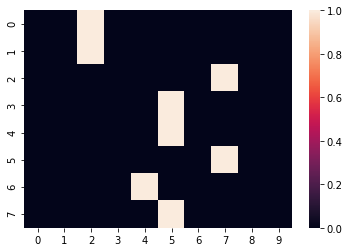

In [118]:
ax = seaborn.heatmap(posterior[:10,])
plt.show()

Here we see that the coders are MUCH more likely to choose values between 4 and 7 (particularly 5 and 7)... which would be similar to if we simply averaged the responses

# Generating Annotations

Pyanno also allows one to generate artificial data from a model.

In [122]:
model = ModelBt.create_initial_state(10, 5, theta=[0.99,0.75, 0.5, 0.25, 0.01])
#randome generate annotations with 10 label classes and 5 annotators. The accuracy of the three annotators are 0.99, 0.75, 0.5, 0.25 and 0.01 respectively.
model.generate_annotations(20)

array([[7, 7, 8, 8, 6],
       [1, 8, 1, 1, 5],
       [2, 2, 4, 8, 4],
       [8, 8, 8, 1, 5],
       [0, 0, 1, 1, 1],
       [0, 0, 3, 4, 2],
       [5, 3, 5, 5, 1],
       [0, 2, 0, 7, 6],
       [0, 0, 5, 0, 7],
       [1, 1, 2, 0, 7],
       [2, 2, 4, 9, 3],
       [5, 5, 5, 4, 9],
       [5, 5, 5, 9, 8],
       [3, 3, 1, 6, 8],
       [3, 3, 8, 3, 9],
       [1, 1, 1, 7, 4],
       [8, 8, 0, 5, 9],
       [0, 0, 8, 6, 9],
       [3, 3, 3, 2, 2],
       [0, 0, 5, 9, 4]])

## Visualizing coder accuracy

Pyanno provides a [graphical user interface](http://docs.enthought.com/uchicago-pyanno/user_guide.html) for making plots. However, it is not compatible with ipython notebooks. Nevertheless, nothing prevents us from making plots using matplotlib. Let's make a plot of the accuracy of each annotator inferred from ModelA.

In [123]:
model = ModelBt.create_initial_state(10, 9)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)#.mean(axis = 1).mean(axis = 1)
y_ci = samples.std(axis=0)#.mean(axis = 1).mean(axis = 1)

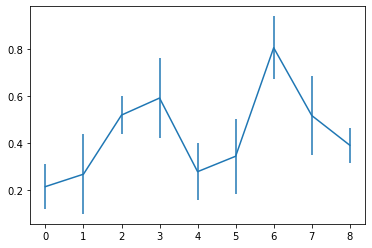

In [124]:
plt.figure()
plt.errorbar(range(9),y, yerr = y_ci)
plt.show()

## Using more of my data

Look at coder agreement

In [125]:
pyanno.measures.agreement.labels_frequency(anno.annotations, 10)#10 possible catagories

array([0.01408451, 0.02816901, 0.09859155, 0.09859155, 0.18309859,
       0.21126761, 0.15492958, 0.12676056, 0.02816901, 0.05633803])

Above we see the user agreement for the 9 users to annotated 10 categories. For each of the 10 categories (1-10 on scale) there is an agreement frequency. We see it is the lowest for a score of 1 (controversial) and highest for a score of 6 (pretty neutral).. makes sense for judging the actions we provided in the description

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 2. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


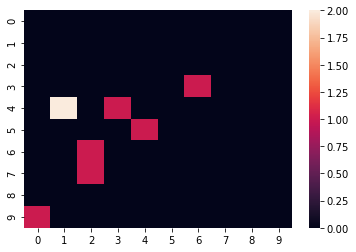

In [127]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1], 10) #10 possible catagories
print(c)
ac = seaborn.heatmap(c)
plt.show()

Most agreement is on 1 interestingly i.e. most people see using twitter generally as a '4' on the scale from 1 (interoverted) to 10 (extroverted)

In [129]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

-0.16363636363636364

In [130]:
krippendorffs_alpha(anno.annotations[::])

-0.005002440214738835

In [131]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

-0.0847457627118644

<AxesSubplot:>

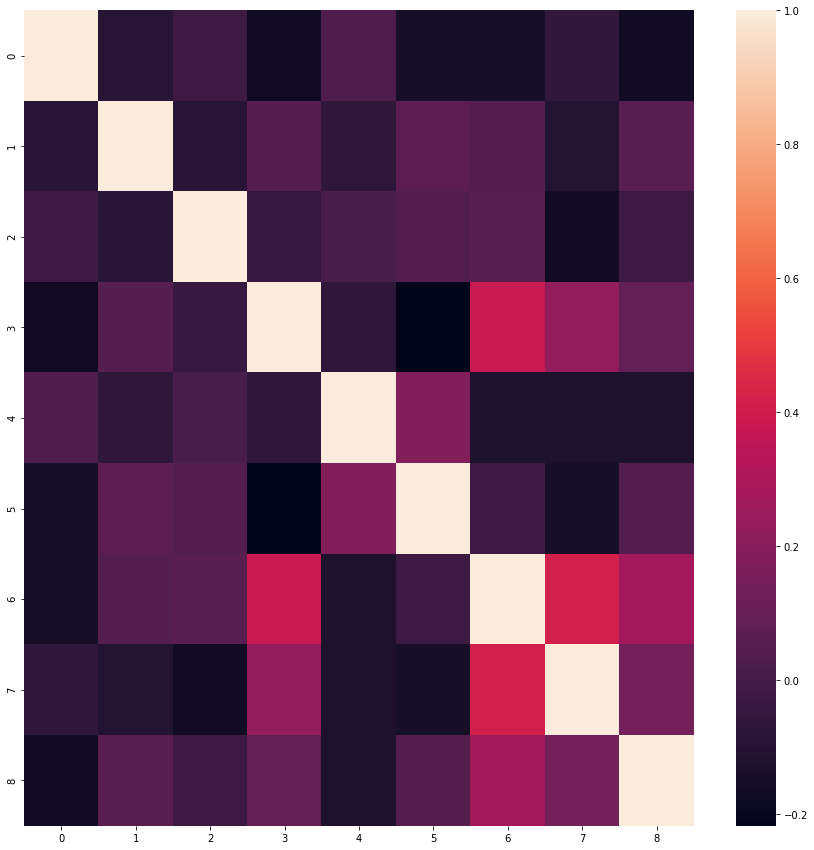

In [132]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
fig, ax = plt.subplots(figsize = (15, 15))
seaborn.heatmap(m, ax =ax)

In [135]:
model_hot = ModelBt.create_initial_state(10, 9)
model_hot.mle(anno.annotations)
print(model.theta)
print(model_hot.log_likelihood(anno.annotations))

[2.71858661e-01 2.80852398e-01 3.01699292e-01 7.40525746e-01
 3.95510451e-08 4.06204004e-01 7.67054857e-01 5.71601159e-01
 5.76290008e-01]
-152.60484794619785


In [136]:
def makeQuestionComparison(model, anno_target, num_questions = 20):
    votes = []
    for r in anno_target.annotations:
        v = [0] * len(anno_target.labels)
        votes.append(v)
        for a in r:
            if a > -1:
                v[a] += 1
    votes_array = np.array(votes)
    posterior = model.infer_labels(anno_target.annotations)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)

    seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
    seaborn.heatmap(np.nan_to_num(posterior,0)[:num_questions], annot=True, ax =ax1)
    ax1.set_title("Model")
    ax2.set_title("Votes")
    return fig, (ax1, ax2)

(<Figure size 1080x720 with 4 Axes>,
 (<AxesSubplot:title={'center':'Model'}>,
  <AxesSubplot:title={'center':'Votes'}>))

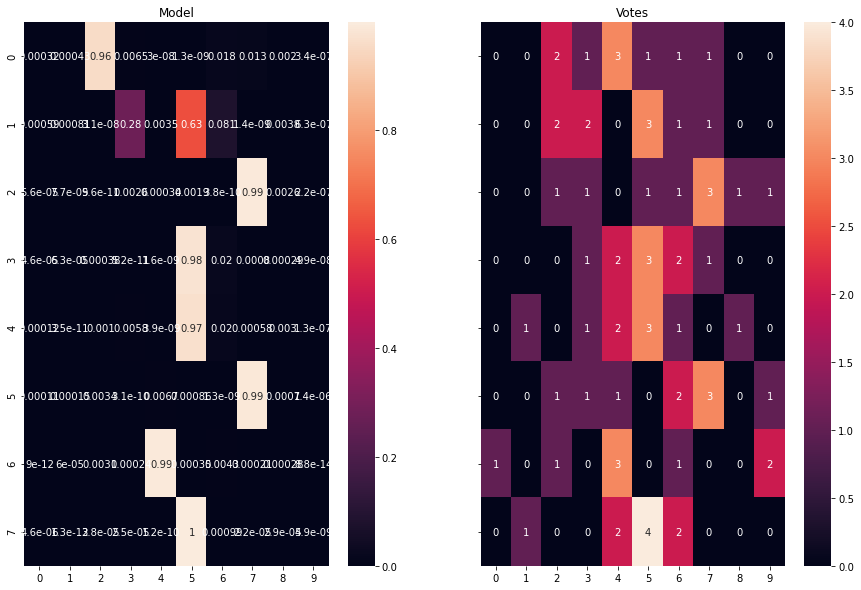

In [138]:
makeQuestionComparison(model_hot, anno)